In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter
import math

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform
from Dataset_Maker_Junctions import make_random_junction_set, make_grey_transform_junc

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# %load_ext autoreload
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [4]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [5]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(
            0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

# Learn 5x5 patches

In [6]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

# with open(data_folder + 'line_data_5_125000_grey_multicolor_with_solid_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_125000_grey_bicolor_with_solid_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_100000_grey_bicolor_noise_random_.2_uncentered.pkl','rb') as f:
with open(data_folder + 'line_data_5_100000_grey_multicolor_with_solid_with_junc_noiseless_uncentered.pkl','rb') as f:


    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

135000


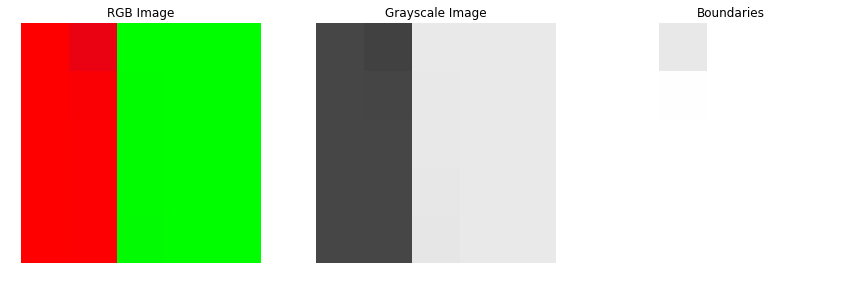

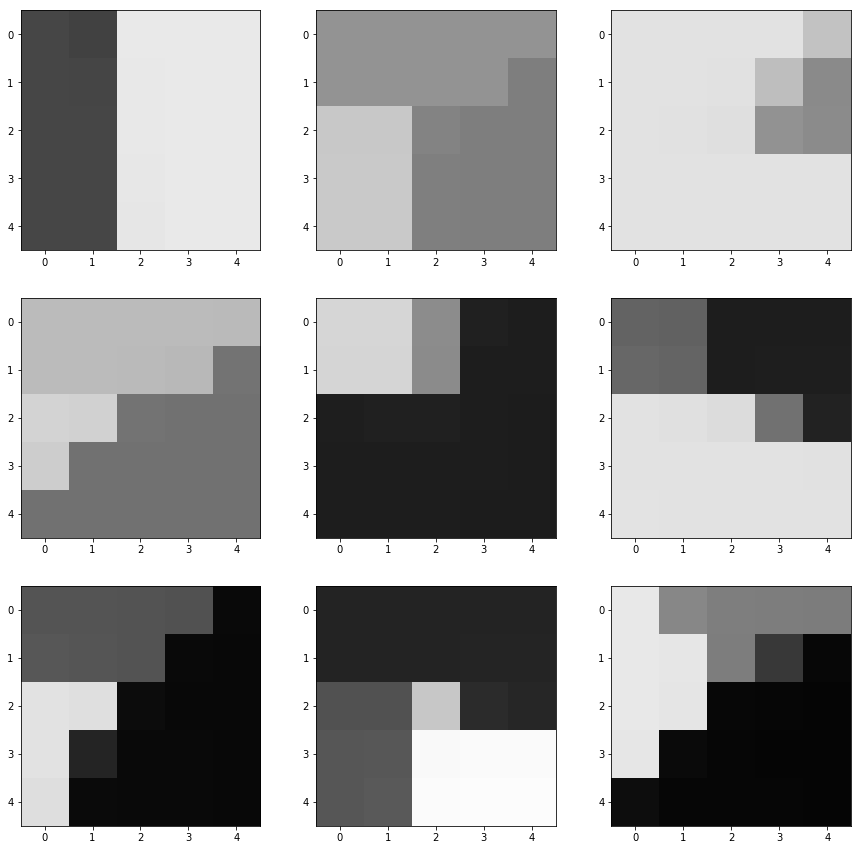

In [7]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = wedges_grey.shape[-1],wedges_grey.shape[-1]

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(331)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(332)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(333)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
#     print(params[-ii,:])

# img_show = 1
# plt.subplot(334)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(335)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(336)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');

# img_show = 2
# plt.subplot(337)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(338)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(339)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');



In [8]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.activate = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(2, stride=1)
#         self.batchnorm = nn.LazyBatchNorm1d()
    
    def forward(self, x):

#         x = self.batchnorm(x)
        x = self.conv1(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
#         x = self.avgpool(x)
        x = self.conv2(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = self.conv3(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
line_model = offCenterLineNet()
line_model = line_model.to(dev)
summary(line_model, input_size=(1, H, W))

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 4]              80
              ReLU-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 16, 2, 2]           2,320
              ReLU-4             [-1, 16, 2, 2]               0
            Conv2d-5             [-1, 32, 1, 1]           2,080
              ReLU-6             [-1, 32, 1, 1]               0
            Linear-7                    [-1, 3]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [319]:
# Now let's train the initial network 

line_model = offCenterLineNet()
line_model = line_model.to(dev)
line_model.apply(weights_init_uniform)

line_model.train();

optimizer = torch.optim.Adam(line_model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 3400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.binary_cross_entropy_with_logits()

sys.quit()

def network_loss(output_gt,output_line_params):
        relu = nn.ReLU()
        
        # Rule to apply:
        gt_a = -torch.sin(output_gt[:,0])
        gt_b = torch.cos(output_gt[:,0])
        gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        
        gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)
        
#         # make the ground truth
#         c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
#         gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
    
        line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))
    
        
        line_loss =  mse_loss(output_line_params*line_in_image.unsqueeze(1),gt_line_params*line_in_image.unsqueeze(1))
        
        
        beta = 5
        
        # if |c| > sqrt(2) + beta, loss is 0
        # else loss increases to the maximum of sqrt(2) + beta when c = 0
        buffer_loss = torch.mean(~line_in_image*relu((np.sqrt(2) + beta - torch.abs(output_line_params[:,2]))))
        
#         buffer_loss = torch.mean(~line_in_image*(torch.abs(torch.abs(output_line_params[:,2]) - beta*(torch.abs(output_line_params[:,0]) + torch.abs(output_line_params[:,1])))))
        
        loss = line_loss + buffer_loss
        
        return loss


    
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(line_model.parameters(),lr=.0005) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = line_model(inputs)
        
        loss = network_loss(output_gt,output_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_line_params = line_model(inputs)

            loss = network_loss(output_gt,output_line_params)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [47]:
# # Save model parameters

# torch.save(line_model.state_dict(), 'model_weights/line_network_noiseless_with_empty_patches.pt')

In [9]:
# line_model.load_state_dict(torch.load('model_weights/line_network_with_empty_patches.pt'));

line_model.load_state_dict(torch.load('model_weights/line_network_noiseless_with_empty_patches.pt'));


tensor(0.1497)
tensor(2.1187)
tensor(1.0499)
tensor(0.4491)
tensor(7.8290)
tensor(6.6400)
tensor(9.8764)


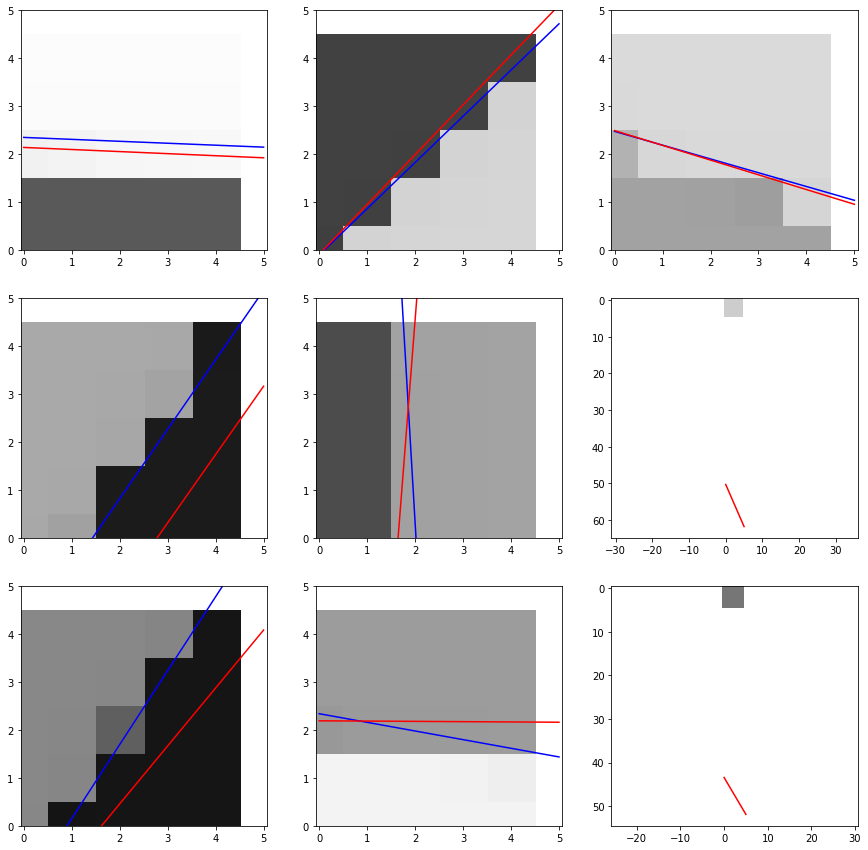

In [10]:
# Plot the Results

line_model.eval();

# ang_loss_all = []

# for batch_i, data in enumerate(test_loader):
    
data = next(enumerate(test_loader))
    
# get the input images and their corresponding labels
inputs, output_gt, _, _ = data[1]
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = line_model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()

c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()


# Calculate angular loss
ang_loss = torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                     ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu()))

# ang_loss_all.append(ang_loss)

gt_a = -torch.sin(output_gt[:,0])
gt_b = torch.cos(output_gt[:,0])
gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])

gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)

line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))


plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    plt.axis('equal')
    
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    
    if line_in_image[ii]:
    # Plot the ground truth lines
        y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]

        plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
        print(ang_loss[ii])
    
        plt.xlim([0,W])
        plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




In [11]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=1)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):
        
#         mean, std = torch.mean(x), torch.std(x)
#         x  = (x-mean)/std
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)
        
        return out
    
R = 16 

big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, R, R))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 15, 15]              80
              ReLU-2           [-1, 16, 15, 15]               0
            Conv2d-3           [-1, 16, 13, 13]           2,320
              ReLU-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 12, 12]           2,080
              ReLU-6           [-1, 32, 12, 12]               0
            Conv2d-7            [-1, 3, 12, 12]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.02
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [12]:
# Copy weights to the new network

offCenterLineNetWeights = line_model.state_dict()
offCenterLineNetWeightsBig = big_model.state_dict()

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    

In [13]:
# # Verify that the model outputs are the same when the input size is the patch size

# c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
# gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    
# print(gt_params)    

# print(big_model(wedges_grey).cpu().detach())
# print(model(wedges_grey).cpu().detach())

In [14]:
def make_random_junction_set(num_samples,img_size,opts,dev,eta=.01,delta=.02):

#     img_size = 64
    img = np.zeros((img_size,img_size,1))

    opts.R                        = img_size
    opts.stride                   = img_size
    opts.eta                      = 0.01
    opts.delta                    = 0.02
    opts.lr_angles                = 0.003
    opts.lr_x0y0                  = 0.03
    opts.lambda_boundary_final    = 0.5
    opts.lambda_color_final       = 0.1
    opts.nvals                    = 31
    opts.num_initialization_iters = 30
    opts.num_refinement_iters     = 1000
    opts.greedy_step_every_iters  = 50
    opts.parallel_mode            = True

#     dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    foj = FieldOfJunctions(img, dev, opts)

    # Bounds of image: [-1,1],[-1,1]
    # Randomly generate junction location from [-3,3],[3,3] and 3 angles between [0,2*pi]

#     jcenter = 2*torch.rand(num_samples,2) - 1
#     jangles = 2*np.pi*torch.rand(num_samples,3) - np.pi
    jangles = 2*np.pi*torch.rand(num_samples,3).to(dev)
#     jcenter = .9*torch.rand(num_samples,2).to(device) - .9
    jcenter = (.2*torch.rand(num_samples,2) - .2).to(dev)
    params = torch.cat([jangles,jcenter],dim=1).unsqueeze(2).unsqueeze(3)
    
    dists = foj.params2dists(params)
    wedges = foj.dists2indicators(dists).squeeze(-1).squeeze(-1)

    params = params
        
    return dists,wedges,params,foj


def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((wedges.shape[0],3,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<wedges.shape[0]:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.max(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[[0.0084]],

         [[0.3834]],

         [[0.9975]]]])


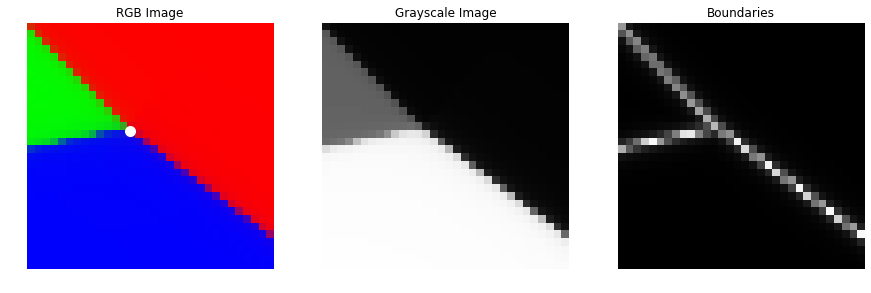

In [15]:
# Produce a junction image

R = 32
add_noise = 0


opts = SimpleNamespace()
dists,wedges,params,foj = make_random_junction_set(1,R,opts,'cpu')

grey_transform = make_grey_transform_junc(wedges.shape[0],'cpu',opt=1)

print(grey_transform)

wedges_grey = (wedges*grey_transform).sum(1).unsqueeze(0)
boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3)

if add_noise:
    wedges_grey = wedges_grey + .5*torch.rand(wedges.shape[0],device='cpu').unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape,device='cpu')
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 


img_show = 0

# TO DO: figure out how to plot the junction center!!
junction_center = (params[img_show,-2:,:,:].squeeze()*R/2 + R/2).cpu()

# print(junction_center)


plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].permute(1,2,0))
plt.plot(junction_center[0],junction_center[1],'wo',markersize=10)
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Boundaries')
plt.axis('off');

wedges_grey = wedges_grey.to(dev)#.unsqueeze(0)


In [16]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3


num_convs = 3
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])
torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


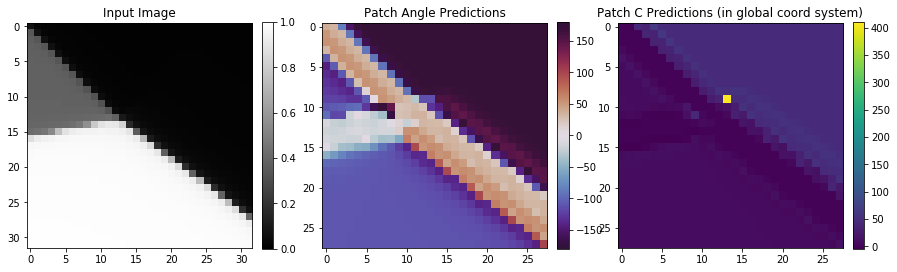

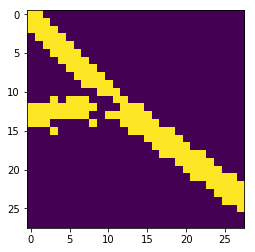

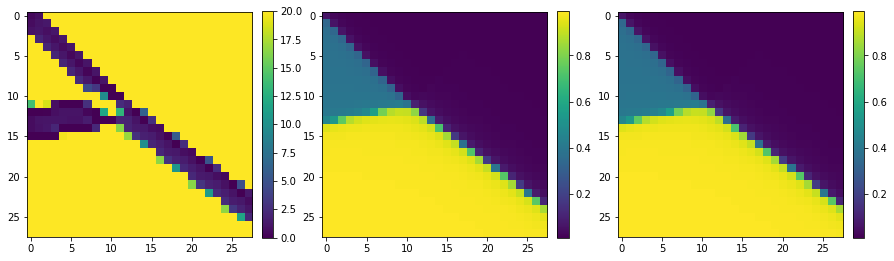

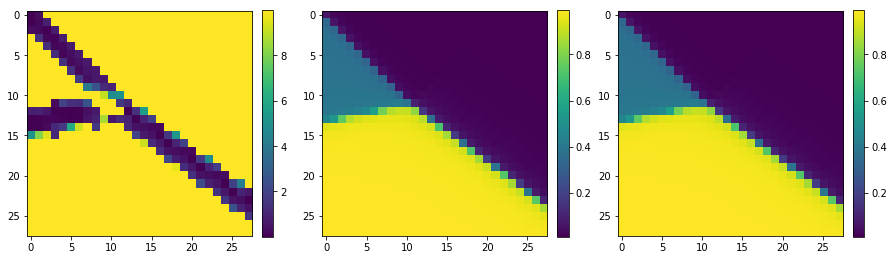

In [17]:
# Plot output of big network

output_line_params = big_model(wedges_grey).cpu().detach()

print(output_line_params.shape)

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(wedges_grey.cpu().detach().squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(output_line_angles,vmin=-180,vmax=180,cmap='twilight_shifted')
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


# Plot prediction error:

# To do this, I first need to create a mapping of the "valid parameters" for each patch
# TBD

# Check which patches predict a line within them

check_patches = (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:])) > torch.abs(output_line_params[0,2,:,:])


plt.figure()
plt.imshow(check_patches)

# How diffferent is each patch from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


dot_prod = torch.sum(avg_patch_params*output_line_params_T,1).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,20))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)


# How diffferent is each patch angle from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


#dot_prod = torch.sum(avg_patch_params[:,:2,:,:]*output_line_params_T[:,:2,:,:],1).squeeze()

dot_prod = torch.abs(avg_patch_params[:,2,:,:]*output_line_params_T[:,2,:,:]).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
# plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,10))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

# Measure how different 



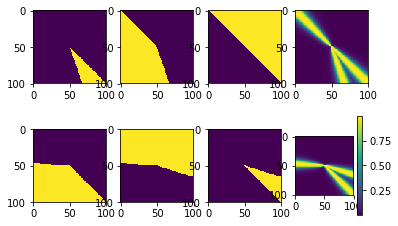

In [18]:
class MultiJunction:
    def __init__(self, order, dev, vertex=None, angle=None, wedges=None):
        """
        Inputs
        ------
        order     Junction order, i.e. number of wedges per junction (positive integer)
        vertex    (x,y) coordinates of vertices for each junction. Accepts an N x 2 array of coordinates
                  If this argument is omitted, the default value is (0.0,0.0).
        angle     Angles in radians representing overall orientation for each junction. Length N array.
                  If this argument is omitted, the default value is 0.0.
        wedges    Relative solid angles of wedges. 2D array of size N x order.
                  If this argument is omitted, the default value is an array of ones
                  (so all wedges have equal solid angles).
        
        Note:     The entries of "wedges" need not sum to 2*pi; they are
                  normalized internally. Also, "wedges" cannot be all zeros.
        """

        # Make sure order is a positive integer
        if isinstance(order, int):
              if order <= 0:
                raise ValueError("Junction order must be a positive integer")
        elif isinstance(order, float):
              if not order.is_integer() or order <= 0:
                raise ValueError("Junction order must be a positive integer")
        else:
              raise ValueError("Junction order must be a positive integer")
                
        self.order = int(order)
        
        # Define wedge vertex
        self.vertex = vertex if vertex is not None else torch.zeros((1,2),device=dev)

        # Define global orientation
        self.angle = angle if angle is not None else 0.0

        # Define wedge solid angles, and normalize for summing to 2*pi
        self.wedges = wedges if wedges is not None else torch.ones((1,order),device=dev)
        self.wedges = self.wedges*(2*torch.pi)/torch.sum(self.wedges,1).unsqueeze(1)
        
        padding = [(1)] + [(0)]
        
        # Compute wedge central angles
        self.centralangles = self.angle.unsqueeze(1) + self.wedges/2 + F.pad(torch.cumsum(self.wedges,dim=1)[:,:-1],padding)

        # Compute wedge boundary angles
        self.boundaryangles = self.angle.unsqueeze(1) + F.pad(torch.cumsum(self.wedges,dim=1)[:,:-1],padding)


    def wedgetest(self,xt,yt):
        """
        Test whether point (xt,yt) is in jth wedge

        Inputs
        ------
        xt, yt          xt is a 1D array of x points being tested, yt is a 1D array of y points being tested

        Output
        ------
        indicator       Binary array: N x |xt| x |yt| x J, where J is order of the junction

        """
        
        # Make sure xt and yt have matching lengths
        if xt.shape[0] != yt.shape[1]:
              raise ValueError("xt and yt must have matching lengths")
                
        indicator = (xt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) \
                        * torch.cos(self.centralangles).unsqueeze(1).unsqueeze(1) + \
                    (yt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) \
                        * torch.sin(self.centralangles).unsqueeze(1).unsqueeze(1)  > \
                    torch.cos(self.wedges/2).unsqueeze(1).unsqueeze(1) * \
                       torch.sqrt((xt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
                               (yt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)
        
        return indicator

    def render_wedges(self,opts):
        """
        Render an integer-valued image of the wedge supports over a square patch

        Inputs
        ------
        opts   Object with the following attributes:
               patchmin          Lower bound (xmin = ymin) of square domain
               patchmax          Upper bound (xmax = ymax) of square domain
               patchres          Number of pixels in each dimension
               delta             Dirac delta relaxation parameter for rendering boundary maps   
               
        Output
        ------
        im    Image of size [patchres, patchres] with integer values in {0...(order-1)}
        """
          
        # coordinate grid of pixel locations 
        xrng = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(0)
        yrng = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(-1)

        return self.wedgetest(xrng,yrng)
    
    def render_boundaries(self,opts):
        """
        Render an image of the wedge boundaries over a square patch

        Inputs
        ------
        opts   Object with the following attributes:
               patchmin          Lower bound (xmin = ymin) of square domain
               patchmax          Upper bound (xmax = ymax) of square domain
               patchres          Number of pixels in each dimension
               delta             Dirac delta relaxation parameter for rendering boundary maps   
             
        Output
        ------
        im    Image of size [patchres, patchres] with values in [0,1]
        """

        # coordinate grid of pixel locations 
        x = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(0)
        y = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(-1)
  
        # Loop over wedge-boundaries and store their boundary maps.
        # Use [1 / (1 + (x/opts.delta)**2 )] for the relaxed dirac distribution 
        ims = 1.0 / (1.0 + (( (x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) * torch.cos(self.boundaryangles).unsqueeze(1).unsqueeze(1) + \
                       (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) * torch.sin(self.boundaryangles).unsqueeze(1).unsqueeze(1) - \
                        torch.sqrt((x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
                                   (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)) \
                      / opts.delta )**2 )  
        
#         ims = 1.0 / (1.0 + (( (x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.cos(self.boundaryangles).unsqueeze(1).unsqueeze(1) + \
#                        (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.sin(self.boundaryangles).unsqueeze(1).unsqueeze(1) - \
#                         torch.sqrt((x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
#                                    (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)) \
#                       / opts.delta )**2 )  
#         ims = 1.0 / (1.0 + torch.exp(-2 * 1/opts.delta * (( (x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.cos(self.boundaryangles).unsqueeze(1).unsqueeze(1) + \
#                        (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.sin(self.boundaryangles).unsqueeze(1).unsqueeze(1) - \
#                         torch.sqrt((x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
#                                    (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)) \
#                        ) ) )    

#         ims = torch.exp(-2 * (( (x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.cos(self.boundaryangles).unsqueeze(1).unsqueeze(1) + \
#                        (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))*torch.sin(self.boundaryangles).unsqueeze(1).unsqueeze(1) - \
#                         torch.sqrt((x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
#                                    (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)) \
#                        )**2/ (2 * opts.delta) ) 
    
#         print(ims.shape)
        # return max over boundary maps 
        return torch.amax(ims,dim=-1)

    
opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  100    # Number of pixels in each dimension of square patch
opts.delta                    =  .01   # Dirac delta relaxation parameter for rendering boundary maps

# create 3-junction with default properties
order = 3
x
centers = torch.zeros((2,2)).to(dev)
angles = torch.tensor((torch.pi/4, torch.pi/4)).to(dev)
solid_angles = torch.tensor([[.1,.6,.7],[.5,.7,.1]]).to(dev)

jn = MultiJunction(order, dev, centers, angles, solid_angles)
    
    
# render indicator functions of all wedges and boundaries
w = jn.render_wedges(opts).cpu()
b = jn.render_boundaries(opts).cpu()

plt.figure()
plt.subplot(241)
plt.imshow(w[0,:,:,0])
plt.subplot(242)
plt.imshow(w[0,:,:,1])
plt.subplot(243)
plt.imshow(w[0,:,:,2])
plt.subplot(244)
plt.imshow(b[0,:,:])
plt.subplot(245)
plt.imshow(w[1,:,:,0])
plt.subplot(246)
plt.imshow(w[1,:,:,1])
plt.subplot(247)
plt.imshow(w[1,:,:,2])
plt.subplot(248)
plt.imshow(b[1,:,:])
plt.colorbar()



In [63]:
# Load dataset 

data_folder = 'foj_data/grayscale_junctions/'


# Start with purely junction images
# with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

In [ ]:
# Create junction finding network 

# Create data structure with optional transforms

class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
            
        # Data generated as: theta1, theta2, theta3, u, v
        # We want representation: alpha (orientation), omega1, omega2, omega3, u, v

        jparam = self.params[index].squeeze()
        center = jparam[3:]
        angles_ord = torch.sort(jparam[:3])[0]
        
#         print(angles_ord)

        omega1 = angles_ord[1]-angles_ord[0]
        omega2 = angles_ord[2]-angles_ord[1]
        omega3 = 2*torch.pi - omega1 - omega2
        
        angles = torch.tensor([angles_ord[0], omega1, omega2, omega3])
        
        jparam_out = torch.cat((angles,center))

        boundary = boundaries[index]

        return image, jparam_out, boundary

    def __len__(self):
        return len(self.images)
    


10000


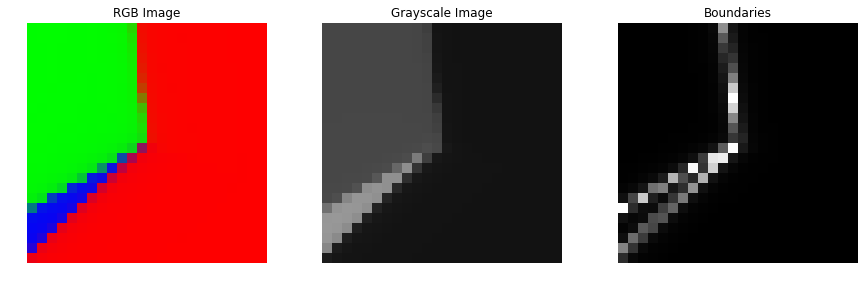

In [31]:
junc_data = JunctionDataset(wedges_grey, params, boundaries, 0)#, transform=trainTransform)
data_size = len(junc_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


# W,H = wedges_grey.shape[-1],wedges_grey.shape[-1]

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(331)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(332)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(333)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

# plt.figure(figsize=[15, 15])

# for ii in range(3):
    
#     plt.subplot(3,3,ii+1)
#     plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)




torch.Size([1, 20, 20, 3]) torch.Size([1, 20, 20])


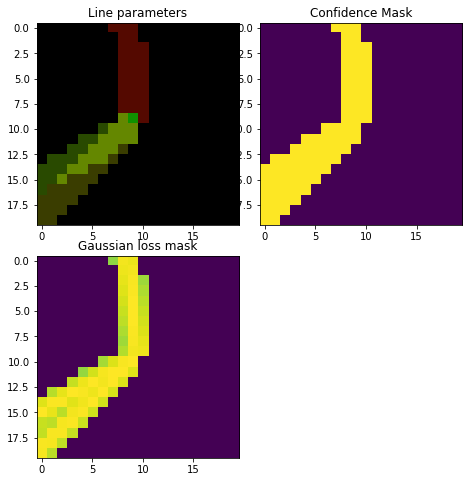

In [68]:
# Let's start by just training the initial neural network with known GT

# Given a set of line parameters, construct the ground truth:

def make_ground_truth(params,H,x0,y0):
    
        theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        cx = params[:,3]
        cy = params[:,4]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        rf = 15 # receptive field size (in the original image)
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        # Create a gaussian mask that is the distance from the line
        sig = .1
        mask3 = torch.exp(-(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)**2/(2*sig**2))

        full_mask = mask1*mask2#*mask3
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        line_params = torch.stack((a,b,c),dim=4)

        ground_truth = torch.mean(line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        
#         confidence = mask2*mask3
#         confidence = confidence/torch.max(confidence.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)
#         confidence,_ = torch.max(confidence,1)
        confidence,_ = torch.max(mask1*mask2,1)#.float()
    
        gaussian_mask,_ = torch.max(mask1*mask2*mask3,1)
        
        return ground_truth,confidence.float(),gaussian_mask
    

gt,c,gm = make_ground_truth(params[0].squeeze().unsqueeze(0),100,x0,y0)

print(gt.shape,c.shape)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0].cpu()))
plt.title('Line parameters')
plt.subplot(222)
plt.imshow(c[0].cpu())
plt.title('Confidence Mask')
plt.subplot(223)
plt.imshow(gm[0].cpu())
plt.title('Gaussian loss mask')
plt.subplots_adjust(wspace=0, hspace=.15)

In [ ]:
# Unfold into lines




In [32]:
# First load the line network:
big_model = offCenterLineNetBig();
big_model = big_model.to(dev)

offCenterLineNetWeights = line_model.state_dict();
offCenterLineNetWeightsBig = big_model.state_dict();

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    
big_model.eval();

In [56]:
class lineToJunctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
#         self.conv1 = nn.Conv2d(3, 3, kernel_size=3) #64 is good
# #         self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
#         self.conv3 = nn.Conv2d(3, 3, kernel_size=3)
        self.fc1 = nn.LazyLinear(30)
        self.fc2 = nn.LazyLinear(30)
        self.fc3 = nn.LazyLinear(360)
        self.activate = nn.ReLU()
        self.sigmoid = nn.Sigmoid
#         self.tanH = nn.Tanh()
#         self.dropout = nn.Dropout(.2)
    
    def forward(self, x):
        
#         x = self.conv1(x)
#         x = self.activate(x)
# #         x = self.conv2(x)
# #         x = self.activate(x)
#         x = self.conv3(x)
        x = x.view(x.shape[0],-1)
#         x = self.activate(x).view(x.shape[0],-1)
        x = self.fc1(x)
#         x = self.dropout(x)
        x = self.activate(x)
        x = self.fc2(x)
        x = self.activate(x)
        x = self.fc3(x)
        
        # The network will output 8 values:
        # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
        
#         print(x.shape)
#         print(x[:,:6].shape)

#         out = self.tanH(x)
        out = self.sigmoid(x)
        
        # First, use sigmoid to ensure first 6 outputs lie between -1 and 1
#         x_norm = self.tanH(x[:,:6])
        
        # Next, need to normalize s/c(theta1), s/c(theta2), s/c(theta3)
        
#         theta1_norm = torch.norm(x_norm[:,:2],dim=1).unsqueeze(1)
#         theta2_norm = torch.norm(x_norm[:,2:4],dim=1).unsqueeze(1)
#         theta3_norm = torch.norm(x_norm[:,4:6],dim=1).unsqueeze(1)

#         out1 = x_norm[:,:2]/theta1_norm
#         out2 = x_norm[:,2:4]/theta2_norm
#         out3 = x_norm[:,4:6]/theta3_norm
        
#         print(out1[:5,:])
#         sys.quit()
        
#         out = torch.cat((out1,out2,out3,x[:,6:]),dim=1)

        return out
    
R = 24

junction_model = lineToJunctionNet()
junction_model = junction_model.to(dev)
summary(junction_model, input_size=(3, R, R))


TypeError: __init__() takes 1 positional argument but 2 were given

In [34]:
# Create function to translate between representations

In [47]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3


num_convs = 3
Wn,Hn = big_model(wedges_grey.to(dev)).shape[-1],big_model(wedges_grey.to(dev)).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya

L = L.to(dev)

In [48]:
# Now let's train the initial network 

model = lineToJunctionNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

In [52]:
optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 100

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

# opts = SimpleNamespace()
# opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
# opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
# opts.patchres                 =  50    # Number of pixels in each dimension of square patch
# opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps


def boundary_loss(output_line_params, output_gt, opts):
    
        b_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4]).render_boundaries(opts).to(dev) 

        # Output junction parameters:
        # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
        # Convert to:
        # alpha, omega1, omega2, omega3, u, v
        
        # alpha = atan2(s(theta1),c(theta1))
        # omega1 = atan2(s(theta2),c(theta2)) - alpha
        # omega2 = atan2(s(theta3),c(theta3)) - omega1
        # omega3 = 2*pi - omega1 - omega2
                
        alpha_out = torch.atan2(output_line_params[:,1],output_line_params[:,0])
        omega1_out = torch.atan2(output_line_params[:,3],output_line_params[:,2]) - alpha_out
        omega2_out = torch.atan2(output_line_params[:,5],output_line_params[:,4]) - omega1_out
        omega3_out = 2*torch.pi - omega1_out - omega2_out
        
        omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
#         jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, output_line_params[:,2:5])
        jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
        b = jn.render_boundaries(opts)
            
        loss = mse_loss(b,b_gt) + .01*torch.mean(torch.norm(output_line_params[:,5:],dim=1))
    
        return b, b_gt, loss
    
    
def cross_entropy_loss(output_line_params, output_gt, opts):
            
        # Calculate the ground truth angles
        angles = torch.round(torch.rad2deg(torch.cumsum(output_gt[:,:3], axis=1)))
        angles = (angles + 360) % 360

        # Convert to a one hot encoding
        angles_gt_oh = F.one_hot(angles[:,0].long(), num_classes=360) \
            + F.one_hot(angles[:,1].long(), num_classes=360) \
            + F.one_hot(angles[:,2].long(), num_classes=360)
        
#         plt.figure()
#         plt.imshow(angles_gt_oh.cpu())
        
#         print(angles_gt_oh)
#         print(output_line_params)
        
#         loss = bce_loss(output_line_params,angles_gt_oh.double())
        loss = mlsm_loss(output_line_params,angles_gt_oh.double())


        
#         print(loss)
    
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    b_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4]).render_boundaries(opts).to(dev) 

    # zero the parameter (weight) gradients
    optimizer.zero_grad()

    # first pass through line parameter network
    line_params = big_model(inputs)
    line_params = torch.einsum('ajbc,ajkbc->akbc',line_params,L)#.permute()
    
#     new_inputs = torch.cat((line_params,inputs[:,:,2:22,2:22]),dim=1)
    new_inputs = line_params
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
#     _,_,loss = boundary_loss(output_line_params,output_gt, opts)
    loss = cross_entropy_loss(output_line_params,output_gt, opts)

    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params,loss
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch == 10:
#         optimizer = torch.optim.Adam(model.parameters(),lr=.0005) 
        
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.04945796450441581, Avg. Test Loss: 0.049377135430638576
Epoch: 2, Avg. Train Loss: 0.049235035841022734, Avg. Test Loss: 0.049181877158223475
Epoch: 3, Avg. Train Loss: 0.04905254351095862, Avg. Test Loss: 0.04902186388861457
Epoch: 4, Avg. Train Loss: 0.0489022033074956, Avg. Test Loss: 0.04889020205542997
Epoch: 5, Avg. Train Loss: 0.04877784888231762, Avg. Test Loss: 0.04878225696519259
Epoch: 6, Avg. Train Loss: 0.0486748614957121, Avg. Test Loss: 0.04869334941391523
Epoch: 7, Avg. Train Loss: 0.048589237585850355, Avg. Test Loss: 0.04861982051212582
Epoch: 8, Avg. Train Loss: 0.0485178984621208, Avg. Test Loss: 0.04855845636691104
Epoch: 9, Avg. Train Loss: 0.04845815941779021, Avg. Test Loss: 0.048507372634488816


KeyboardInterrupt: 

tensor([[-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529],
        [-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529],
        [-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529],
        ...,
        [-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529],
        [-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529],
        [-4.5467, -4.5861, -4.5816,  ..., -4.5395, -4.4645, -4.5529]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


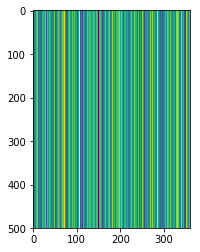

In [53]:
# Visualize the output of the network for boundary loss

data = next(iter(test_loader))

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .05   # Dirac delta relaxation parameter for rendering boundary maps

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)


print(output_line_params)

plt.figure()
plt.imshow(output_line_params.cpu().detach())

# gt_line_params = data[1].to(dev)

# print(output_line_params[0])

# # print(output_line_params[:5,:])

# b, b_gt,_ = boundary_loss(output_line_params, gt_line_params, opts)

# # print(b.shape,b_gt.shape)

# plt.figure(figsize=[5,15])

# num_plot = 8

# for ii in range(num_plot):
    
#     plt.subplot(num_plot,2,2*ii+1)
#     plt.imshow(b[ii].cpu().detach())
#     plt.subplot(num_plot,2,2*ii+2)
#     plt.imshow(b_gt[ii].cpu())

tensor([ 3.3413e-03, -9.9999e-01,  1.9811e-02,  9.9980e-01,  1.0000e+00,
         2.3945e-04,  1.4685e-09,  1.1036e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


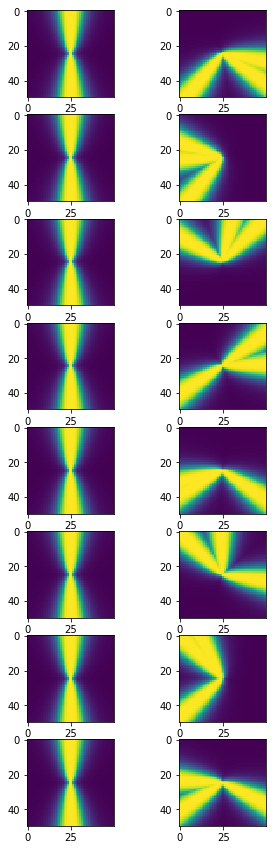

In [302]:
# Visualize the output of the network for boundary loss

data = next(iter(test_loader))

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .05   # Dirac delta relaxation parameter for rendering boundary maps

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

print(output_line_params[0])

# print(output_line_params[:5,:])

b, b_gt,_ = boundary_loss(output_line_params, gt_line_params, opts)

# print(b.shape,b_gt.shape)

plt.figure(figsize=[5,15])

num_plot = 8

for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

In [ ]:
# def network_loss(output_line_params, output_gt, opts):

    
# #         jn_gt = jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
# #         b_gt = jn_gt.render_boundaries(opts).to(dev)
        
#         # Convert gt into output format:
#         # Gt junction parameters:
#         # alpha, omega1, omega2, omega3, u, v
#         # c(theta1), s(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # c(theta1) = torch.cos(alpha)
#         # s(theta1) = torch.sin(alpha)
#         # c(theta2) = torch.cos(alpha + omega1)
#         # s(theta2) = torch.sin(alpha + omega1)
#         # c(theta3) = torch.cos(alpha + omega1 + omega2)
#         # s(theta2) = torch.sin(alpha + omega1 + omega2)
        
#         ct1 = torch.cos(output_gt[:,0]).unsqueeze(1)
#         st1 = torch.sin(output_gt[:,0]).unsqueeze(1)
#         ct2 = torch.cos(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         st2 = torch.sin(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         ct3 = torch.cos(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         st3 = torch.sin(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         u = output_gt[:,4].unsqueeze(1)
#         v = output_gt[:,5].unsqueeze(1)
        
#         gt_reformat = torch.cat((ct1,st1,ct2,st2,ct3,st3,u,v),dim=1)
        
#         loss = mse_loss(output_line_params,gt_reformat)
#         # Output junction parameters:
#         # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # Convert to:
#         # alpha, omega1, omega2, omega3, u, v
        
#         # alpha = atan2(s(theta1),c(theta1))
#         # omega1 = atan2(s(theta2),c(theta2)) - alpha
#         # omega2 = atan2(s(theta3),c(theta3)) - omega1
#         # omega3 = 2*pi - omega1 - omega2
        
# #         print(output_line_params.shape)
        
# #         alpha_out = torch.atan2(output_line_params[:,1],output_line_params[:,0])
# #         omega1_out = torch.atan2(output_line_params[:,3],output_line_params[:,2]) - alpha_out
# #         omega2_out = torch.atan2(output_line_params[:,5],output_line_params[:,4]) - omega1_out
# #         omega3_out = 2*torch.pi - omega1_out - omega2_out
        
# #         omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
# #         jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, output_line_params[:,2:5])
# #         jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
# #         b = jn.render_boundaries(opts)
                
# #         loss = mse_loss(b,b_gt) #+ .1*torch.mean(torch.norm(output_line_params[:,5:],dim=1))
    
#         return b, b_gt, loss


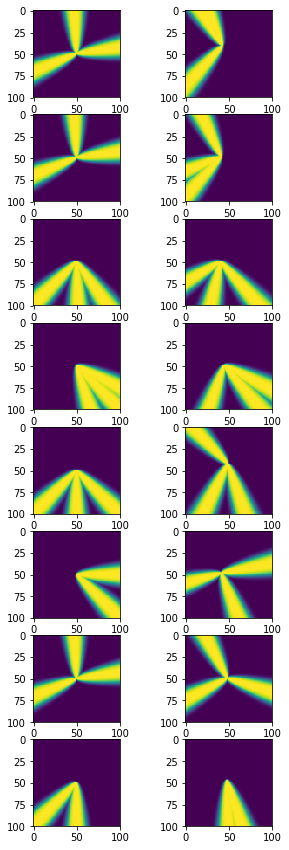

In [585]:
data = next(iter(test_loader))

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

# print(output_line_params[:5,:])

b, b_gt,_ = network_loss(output_line_params, gt_line_params, opts)

# print(b.shape,b_gt.shape)

plt.figure(figsize=[5,15])

num_plot = 8

for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

In [ ]:
# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 4

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)

low_var = running_var.squeeze()<100
low_var_2 = running_var_2.squeeze()<100

plt.imshow(low_var)
plt.subplot(122)
plt.imshow(low_var_2)
# plt.colorbar()

# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))

